In [1]:
import os
### import tf and shut up tensorflow deprecation warnings ####
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np

### import facenet repo ####
import sys

#### OpenCV and matplotlib imports
# import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
# useful for finding the xml file CV2 needs for detection
import pkg_resources

from PIL import Image

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

import seaborn

IMG_WIDTH = 160
IMG_HEIGHT = 160
IMG_CHANNELS = 3

DATASET_BASE = "/data/vggface/test"

BASE_MODELS_PATH = "/home/ivan/adversarial_faces/weights-facenet"
MODEL_TO_CHECKPOINT = {
    "20180408-102900": "model-20180408-102900.ckpt-90",
    "20180402-114759": "model-20180402-114759.ckpt-275"
}
KERAS_MODEL_PATH = "keras-facenet/model/facenet_keras.h5"
OPENCV_HAAR_PATH = "opencv-data/haarcascades"

In [2]:
BOUNDING_BOXES = {}
with open(os.path.join("/data/vggface", "bb_landmark", "loose_bb_test.csv")) as f:
    header = next(f)
    for l in f:
        l = l.strip("\n")
        name_id, x, y, w, h = l.split(",")
        name_id = name_id.strip("\"") + ".jpg"
        BOUNDING_BOXES[name_id] = (int(x), int(y), int(w), int(h))

In [3]:
# def detect_face(img):
#     face_cascade = cv2.CascadeClassifier(OPENCV_HAAR_PATH)
#     assert not (img is None)
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     return face_cascade.detectMultiScale(gray)
    
# def crop_resize_to_face(img):
#     faces = detect_face(img)
#     # if we have detected faces, pick the first one
#     if len(faces) > 0:
#         x, y, w, h = faces[0]
#         img = img[y : y + h, x : x + w, :]
#     return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
def load_test_list(path):
    s2f = {}
    with open(path, "r") as f:
        for l in f:
            l = l.strip("\n")
            subject, file = l.split("/")
            if subject in s2f:
                s2f[subject].append(l)
            else:
                s2f[subject] = [l]
    return s2f

def plot_distances(base_identity_vectors, other_identity_vectors, dist_func=euclidean_distances):
    plt.figure()
    self_dist = pairwise_self(base_identity_vectors, dist_func=dist_func)
    seaborn.distplot(self_dist, label="base identity to self", hist=False)
    
    for indx, other in enumerate(other_identity_vectors):
        random_subset = np.random.choice(len(other), len(base_identity_vectors))
        other = np.take(other, random_subset, axis=0)
        seaborn.distplot(
            np.ravel(dist_func(base_identity_vectors, other)), 
            hist=False, 
            label="base to different identity"
        )
    plt.legend()

def get_error_stats_at_threshold(same_identity_distances, different_identity_distances, threshold):
    same_identity_distances = np.array(same_identity_distances)
    different_identity_distances = np.array(different_identity_distances)
    if len(different_identity_distances.shape) > 1:
        raise Exception("Expeced different identity distances to be of rank 1 but is shape {0}".format(different_identity_distances.shape))
    if len(same_identity_distances.shape) > 1:
        raise Exception("Expeced same identity distances to be of rank 1 but is shape {0}".format(same_identity_distances.shape))

    tpr = np.count_nonzero(same_identity_distances <= threshold) / float(len(same_identity_distances))
    fpr = np.count_nonzero(different_identity_distances <= threshold) / float(len(different_identity_distances))
    return tpr, fpr

def pairwise_self(vectors, dist_func=euclidean_distances):
    arr = dist_func(vectors, vectors)
    return arr[np.tril_indices(len(arr))]

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y

def load_crop_cv2(path):
    full_path = os.path.join(DATASET_BASE, path)
    img = cv2.imread(full_path)
    assert not (img is None), "Image at full path {} is None".format(full_path)
    return crop_resize_to_face(
        cv2.cvtColor(
            img, 
            cv2.COLOR_BGR2RGB
        ))

def load_crop_pillow_provided_landmarks(path):
    x, y, w, h = BOUNDING_BOXES[path]
    img = Image.open(os.path.join(DATASET_BASE, path))
    assert not (img is None)
    img = img.crop((x, y, x + w, y + h))
    return np.array(img.resize((IMG_WIDTH, IMG_HEIGHT)))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    """
    Normalizes an embedding to have unit length in the l2 metric.

    Args:
     x: A batch of numpy embeddings
    """ 
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                        axis=axis,
                                        keepdims=True),
                                 epsilon))
    return output

def do_model(
    load_preprocess_func,
    num_subjects=3,
    dist_func=euclidean_distances
):
    subj2vects = []
    model = tf.keras.models.load_model(KERAS_MODEL_PATH)
    
    for subject in sorted(subj2files.keys())[:3]:
        curr_subj_imgs = np.array([load_preprocess_func(x) for x in subj2files[subject]])

        plt.figure()
        plt.imshow(curr_subj_imgs[0])        
        curr_subj_vects = l2_normalize(model.predict(curr_subj_imgs))
        subj2vects.append(curr_subj_vects)

    for indx in range(num_subjects):
        other_indices = set(range(num_subjects)) - set([indx])
        other_vects = []
        for j in other_indices:
            other_vects.append(subj2vects[j])
        plot_distances(subj2vects[indx], other_vects, dist_func=dist_func)

    all_same_identity = []
    for x in subj2vects[:1]:
        all_same_identity.extend(pairwise_self(x, dist_func=dist_func))

    all_different_identity = []
    for i in range(len(subj2vects)):
        for j in set(range(len(subj2vects))) - set([i]):
            all_different_identity.extend(np.ravel(dist_func(subj2vects[i], subj2vects[j])))

    roc_curve = np.array([get_error_stats_at_threshold(
        all_same_identity,
        all_different_identity,
        x
    ) for x in np.arange(1e-6, 2.0, 0.01)])
    plt.figure()
    plt.plot(roc_curve[:, 1], roc_curve[:, 0], label="roc curve")
    plt.plot(np.arange(0.0, 1.0, 0.05), np.arange(0.0, 1.0, 0.05), label="y=x")
    plt.legend()
    


In [4]:
subj2files = load_test_list(os.path.join("/data/vggface", "test_list.txt"))

In [5]:
# do_model(
#     dist_func=cosine_distances,
#     load_preprocess_func=lambda im: prewhiten(load_crop_cv2(im))
# )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


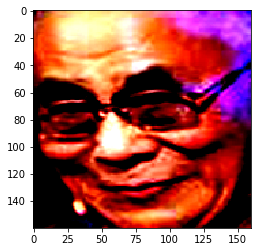

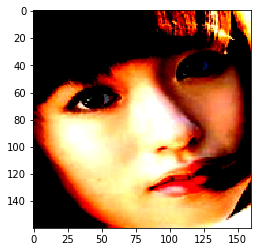

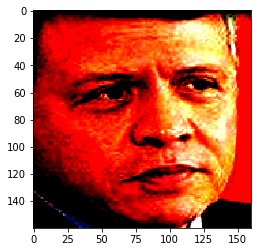

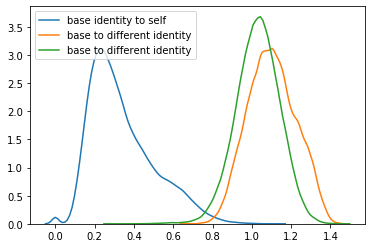

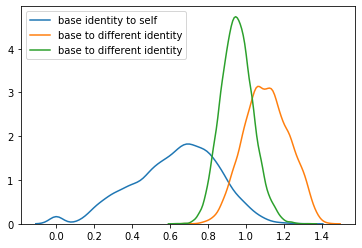

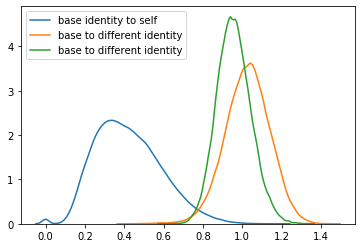

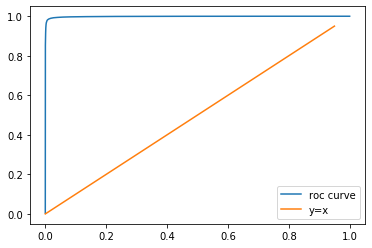

In [6]:
do_model(
     dist_func=cosine_distances, 
     load_preprocess_func=lambda im: prewhiten(load_crop_pillow_provided_landmarks(im))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


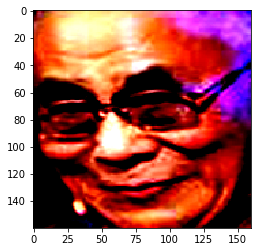

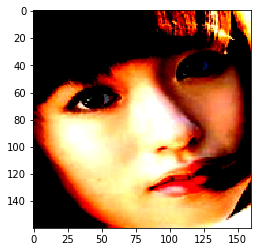

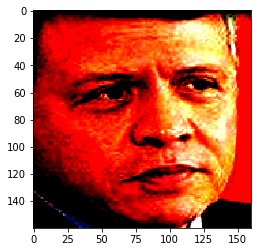

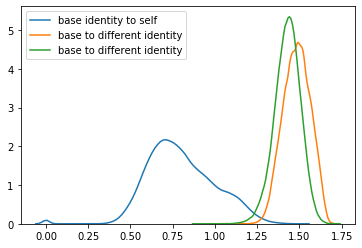

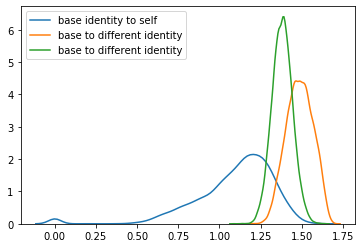

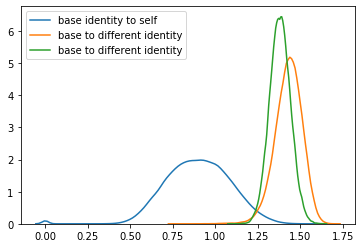

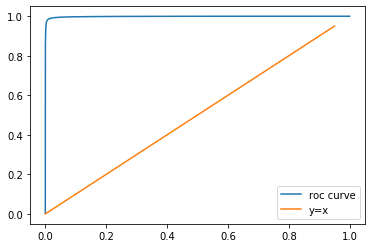

In [7]:
do_model(
     dist_func=euclidean_distances, 
     load_preprocess_func=lambda im: prewhiten(load_crop_pillow_provided_landmarks(im))
)